In [3]:
import pandas as pd
import numpy as np

# ----------------------------------------
# CONFIGURATION
# ----------------------------------------
from google.colab import drive
drive.mount('/content/drive')
PEDESTRIAN_FILE = '/content/drive/Pedestrian_Coordinates.txt'
PLATFORM_FILE = '/content/drive/Platform_Design_Coordinates.txt'
FRAME_RATE = 4  # 4 frames per second

# ----------------------------------------
# LOAD AND CLEAN PEDESTRIAN DATA
# ----------------------------------------
# Skip metadata lines starting with '#'
# Load the full pedestrian data
df = pd.read_csv(PEDESTRIAN_FILE, comment='#', delim_whitespace=True,
                          names=['id', 'frame', 'x', 'y', 'z'])
# Add time-in-seconds column
df["second"] = df["frame"] // 4

# Get the last frame (highest frame) in each second group
last_frame_indices = df.groupby(['id', 'second'])['frame'].idxmax()

# Use these indices to get the last row per second
agg_df = df.loc[last_frame_indices].reset_index(drop=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-3-787583064>:18: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(PEDESTRIAN_FILE, comment='#', delim_whitespace=True,


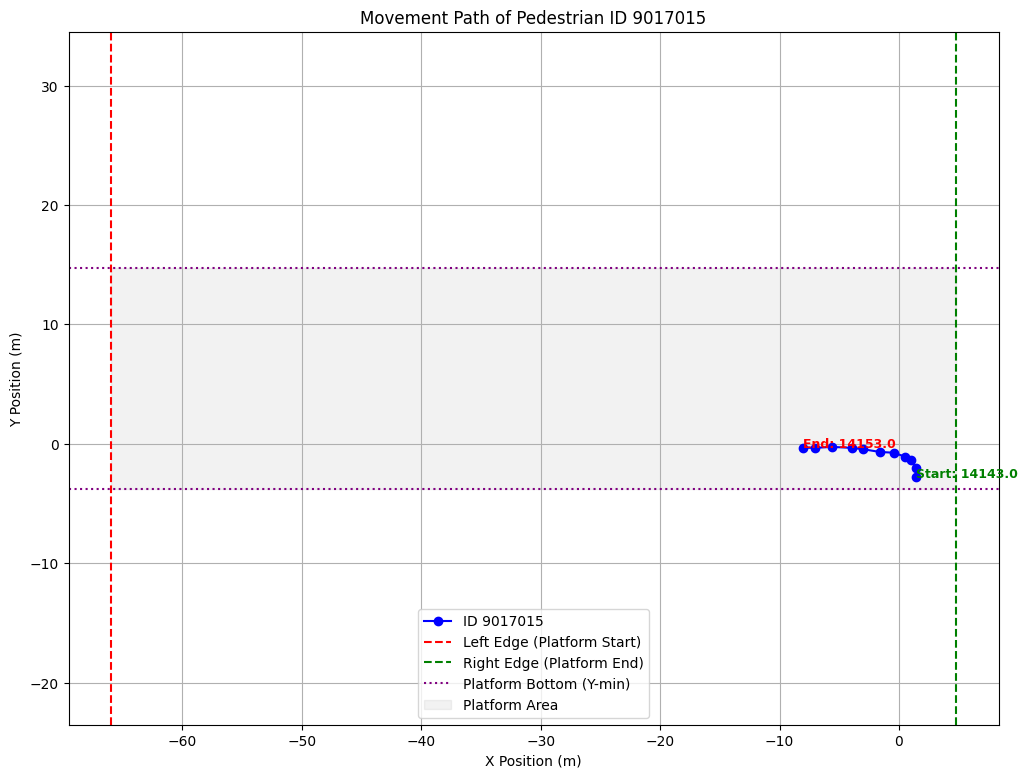

In [ ]:
# Choose a person to analyze
person_id = 9017015  # Change this ID as needed
plot_person_with_platform_edges(person_id, platform_left_x=-66, platform_right_x=4.8, platform_ymin=-3.77, platform_ymax=14.75)

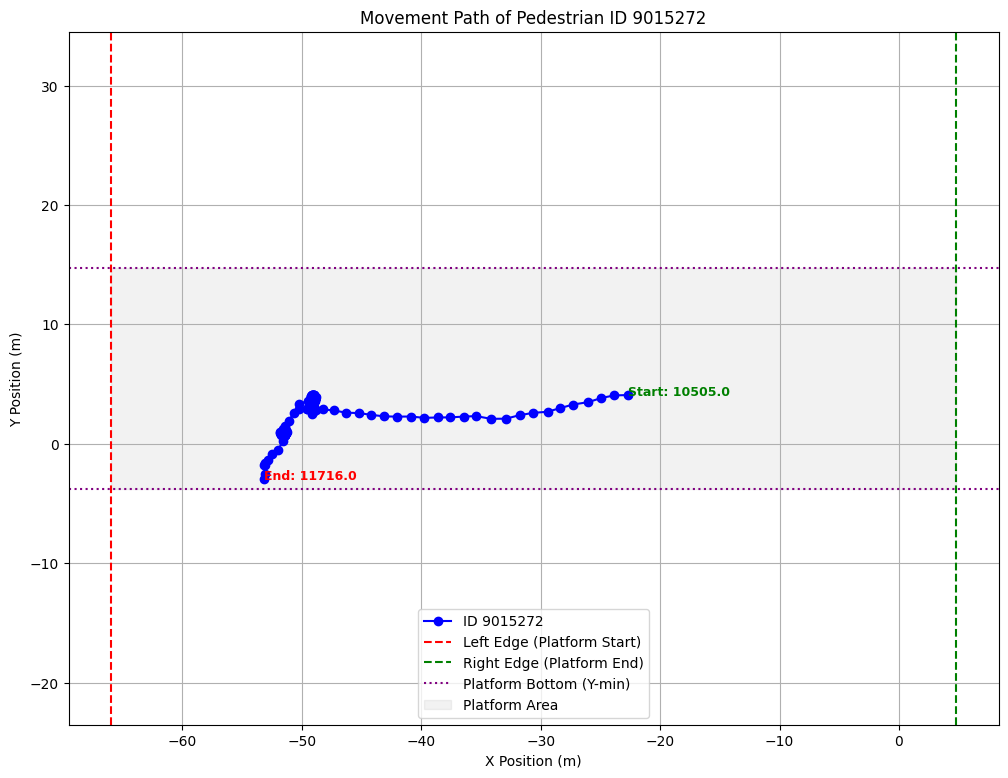

In [ ]:
# Choose a person to analyze
person_id = 9015272  # Change this ID as needed
plot_person_with_platform_edges(person_id, platform_left_x=-66, platform_right_x=4.8, platform_ymin=-3.77, platform_ymax=14.75)

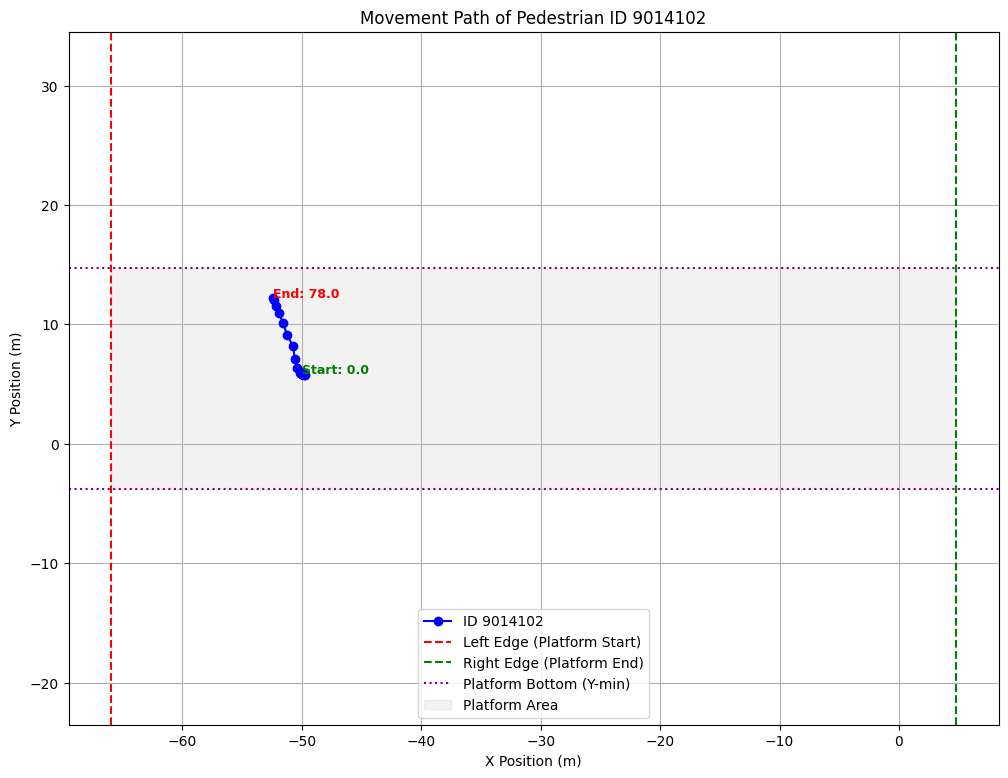

In [ ]:
# Choose a person to analyze
person_id = 9014102  # Change this ID as needed
plot_person_with_platform_edges(person_id, platform_left_x=-66, platform_right_x=4.8, platform_ymin=-3.77, platform_ymax=14.75)

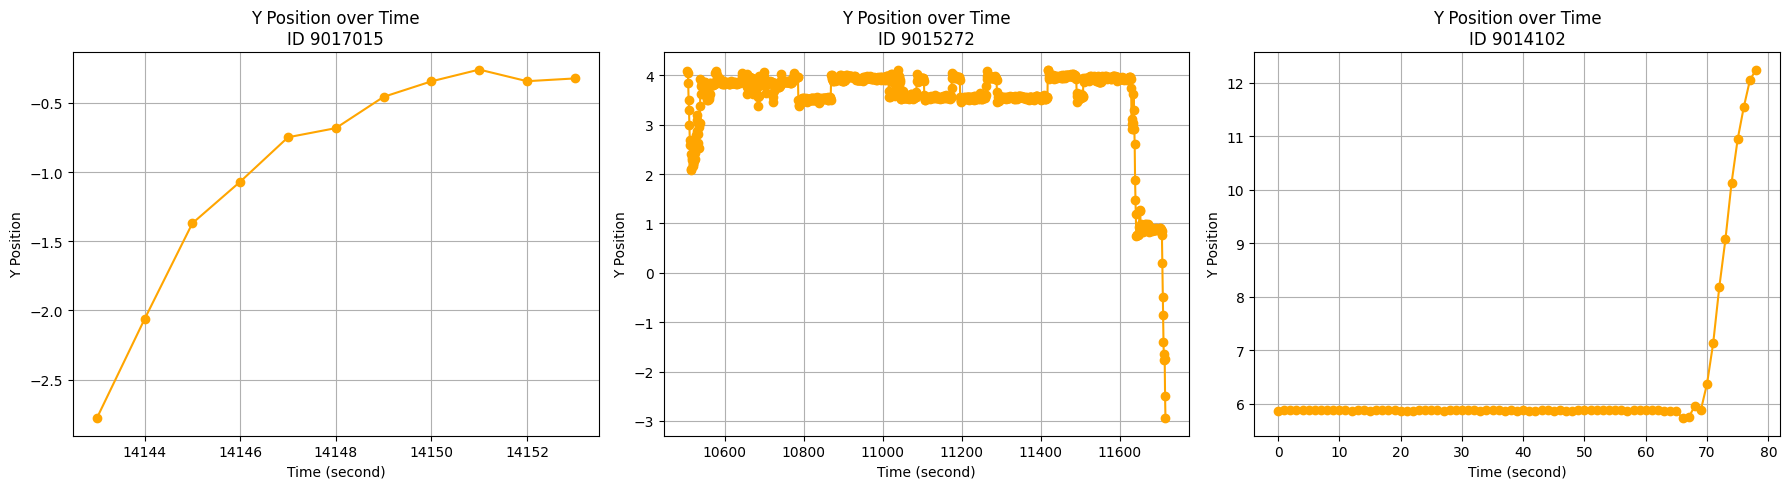

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# List of 3 pedestrian IDs
person_ids = [9017015, 9015272, 9014102]  # Replace with your actual IDs

# Set up the subplot layout
plt.figure(figsize=(18, 5))  # Wider figure for 3 plots

for i, person_id in enumerate(person_ids):
    person_df = agg_df[agg_df['id'] == person_id]

    plt.subplot(1, 3, i + 1)
    plt.plot(person_df['second'], person_df['y'], marker='o', color='orange')
    plt.title(f'Y Position over Time\nID {person_id}')
    plt.xlabel('Time (second)')
    plt.ylabel('Y Position')
    plt.grid(True)

plt.tight_layout()
plt.show()


## Density based Approach: Static Measurment Line

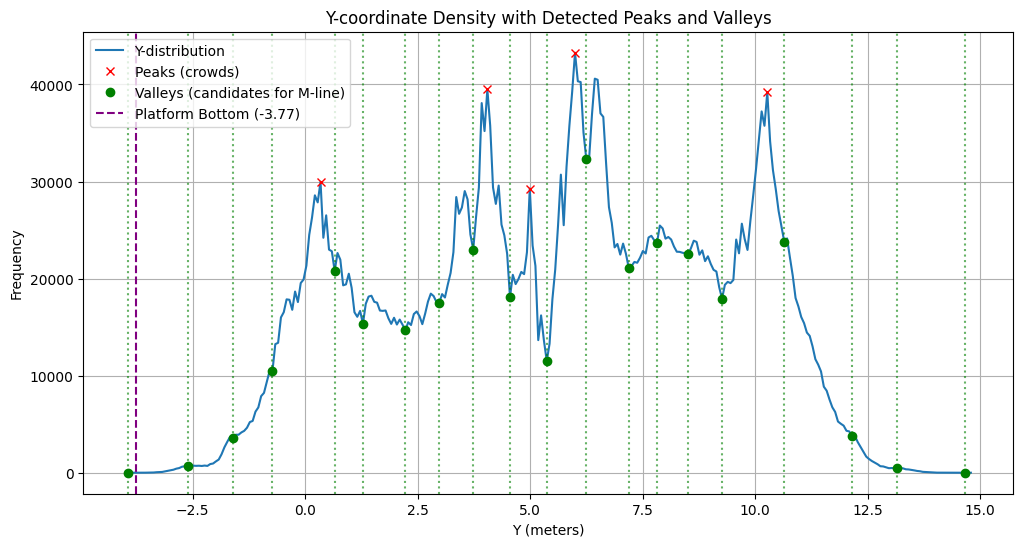

In [ ]:
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

# Get Y histogram
counts, bin_edges = np.histogram(agg_df['y'], bins=300)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Find peaks (dense areas)
peaks, _ = find_peaks(counts, distance=10, prominence=5000)

# Find valleys (inverted peaks)
valleys, _ = find_peaks(-counts, distance=10)

# Plot everything
plt.figure(figsize=(12, 6))
plt.plot(bin_centers, counts, label='Y-distribution')
plt.plot(bin_centers[peaks], counts[peaks], 'rx', label='Peaks (crowds)')
plt.plot(bin_centers[valleys], counts[valleys], 'go', label='Valleys (candidates for M-line)')

# Add vertical lines at valley positions
for x in bin_centers[valleys]:
    plt.axvline(x, color='green', linestyle=':', alpha=0.6)  # vertical line at valley

# Mark platform bottom
plt.axvline(-3.77, color='purple', linestyle='--', label='Platform Bottom (-3.77)')

plt.title("Y-coordinate Density with Detected Peaks and Valleys")
plt.xlabel("Y (meters)")
plt.ylabel("Frequency")
plt.grid(True)
plt.legend()
plt.show()


Technique 1 : Classify passangers basis Measurement Line (Density Based approch)

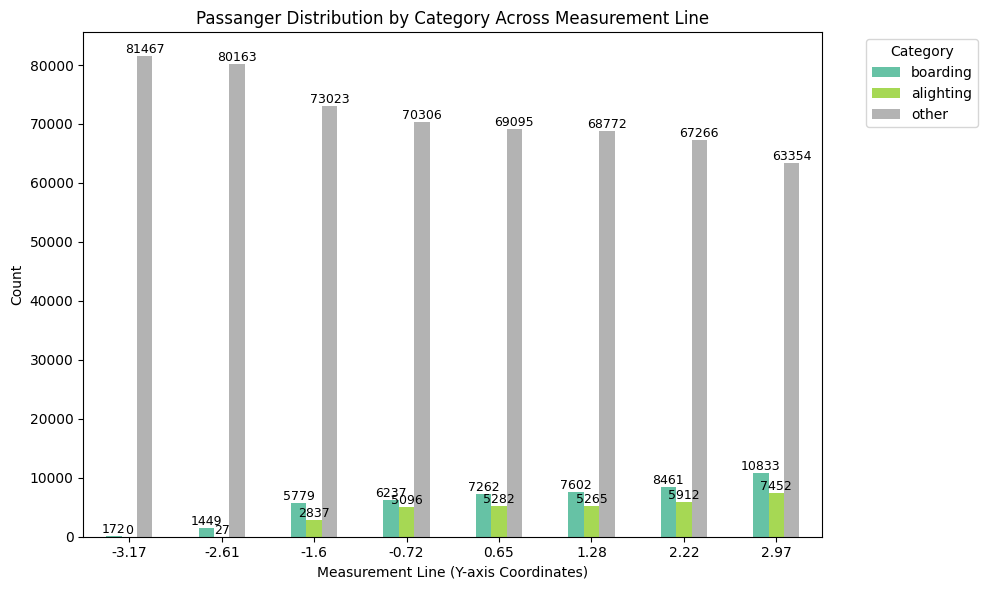

In [5]:
# To Classify the passangers in to categories - Boarding, Alighting and Others

# Set M Line as index for plotting
df_plot = df_plotting_category_classification.set_index('Measurement  Line')[['boarding', 'alighting', 'other']]

# Plot side-by-side bars
ax = df_plot.plot(kind='bar', figsize=(10, 6), colormap='Set2')

# Add annotations to each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', label_type='edge', fontsize=9)

plt.title("Passanger Distribution by Category Across Measurement Line")
plt.ylabel("Count")
plt.xlabel("Measurement Line (Y-axis Coordinates)")
plt.xticks(rotation=0)
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Density based Approach: Dynamically identifying the Measurment Line
### To start the analysis we have taken peak period such as 8 am and 9 am in the morning

In [40]:
import pandas as pd

# Load your data here; assuming it's already in a DataFrame called df
# Ensure 'frame' column is of integer type
df['frame'] = df['frame'].astype(int)

rush_start01, rush_end01 = 100800, 115200
agg_df_rush_morning_8_9 = df[(df['frame'] >= rush_start01) & (df['frame'] <= rush_end01)].copy()

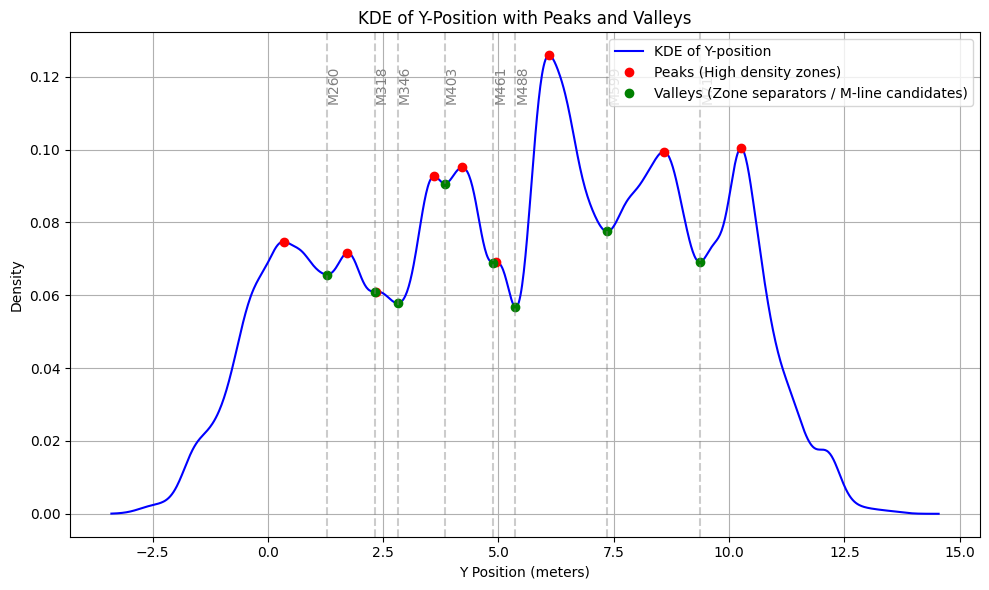

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks

# Extract Y positions
y_values = agg_df_rush_morning_8_9['y'].values

# Compute KDE
kde = gaussian_kde(y_values, bw_method='scott')
y_grid = np.linspace(min(y_values), max(y_values), 1000)
density = kde(y_grid)

# Find peaks and valleys
peaks, _ = find_peaks(density, distance=20)
valleys, _ = find_peaks(-density, distance=20)

# Plot KDE
plt.figure(figsize=(10, 6))
plt.plot(y_grid, density, label='KDE of Y-position', color='blue')

# Overlay peaks
plt.plot(y_grid[peaks], density[peaks], 'ro', label='Peaks (High density zones)')

# Overlay valleys
plt.plot(y_grid[valleys], density[valleys], 'go', label='Valleys (Zone separators / M-line candidates)')

# Annotate M-line candidates
for v in valleys:
    plt.axvline(x=y_grid[v], color='gray', linestyle='--', alpha=0.4)
    plt.text(y_grid[v], max(density)*0.9, f'M{v}', rotation=90, color='gray')

# Labels and legend
plt.title("KDE of Y-Position with Peaks and Valleys")
plt.xlabel("Y Position (meters)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [42]:
def assign_zone(y, boundaries):
    for i, b in enumerate(boundaries):
        if y < b:
            return i
    return len(boundaries)  # if greater than last boundary

def categorize_passengers(df, zone_boundaries, movement_threshold=0):
    df = df.copy()
    df['zone'] = df['y'].apply(lambda y: assign_zone(y, zone_boundaries))

    passenger_categories = []

    for pid, group in df.groupby('id'):
        zones = group['zone'].values
        start_zone = zones[0]
        end_zone = zones[-1]
        zone_diff = end_zone - start_zone
        if zone_diff > movement_threshold:
            category = 'alighting'
        elif zone_diff < -movement_threshold:
            category = 'boarding'
        else:
            category = 'other'

        passenger_categories.append({'id': pid, 'category': category, 'zone': end_zone})

    return pd.DataFrame(passenger_categories)


In [43]:
# zone_boundaries are the y positions at valleys
zone_boundaries = y_grid[valleys]
result_df = categorize_passengers(agg_df_rush_morning_8_9, zone_boundaries)
print(result_df['category'].value_counts())


category
alighting    2212
other        2107
boarding     1539
Name: count, dtype: int64


<ipython-input-46-1366847600>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='category', y='count', data=category_counts, palette='pastel')


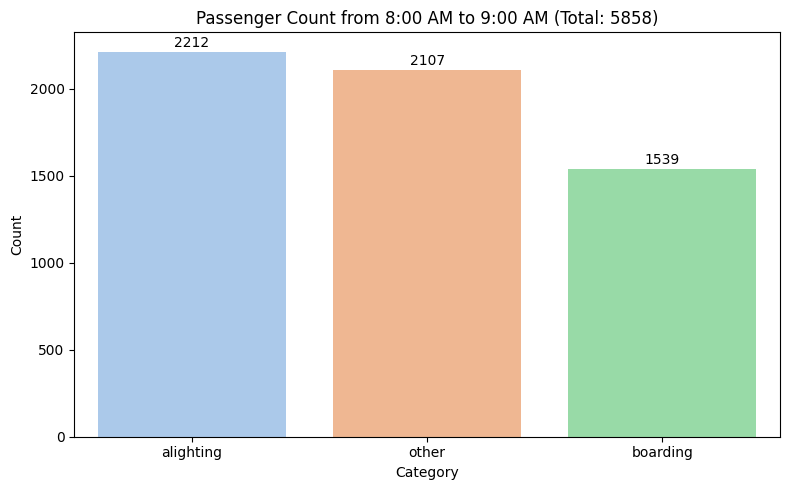

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Count occurrences of each category
category_counts = result_df['category'].value_counts().reset_index()
category_counts.columns = ['category', 'count']

# Calculate total passengers
total_passengers = category_counts['count'].sum()

# Plotting
plt.figure(figsize=(8, 5))
sns.barplot(x='category', y='count', data=category_counts, palette='pastel')

# Add count labels on top of bars
for i, row in category_counts.iterrows():
    plt.text(i, row['count'] + 10, row['count'], ha='center', va='bottom')

# Clean title with total count
plt.title(f'Passenger Count from 8:00 AM to 9:00 AM (Total: {total_passengers})', fontsize=12)
plt.xlabel('Category')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

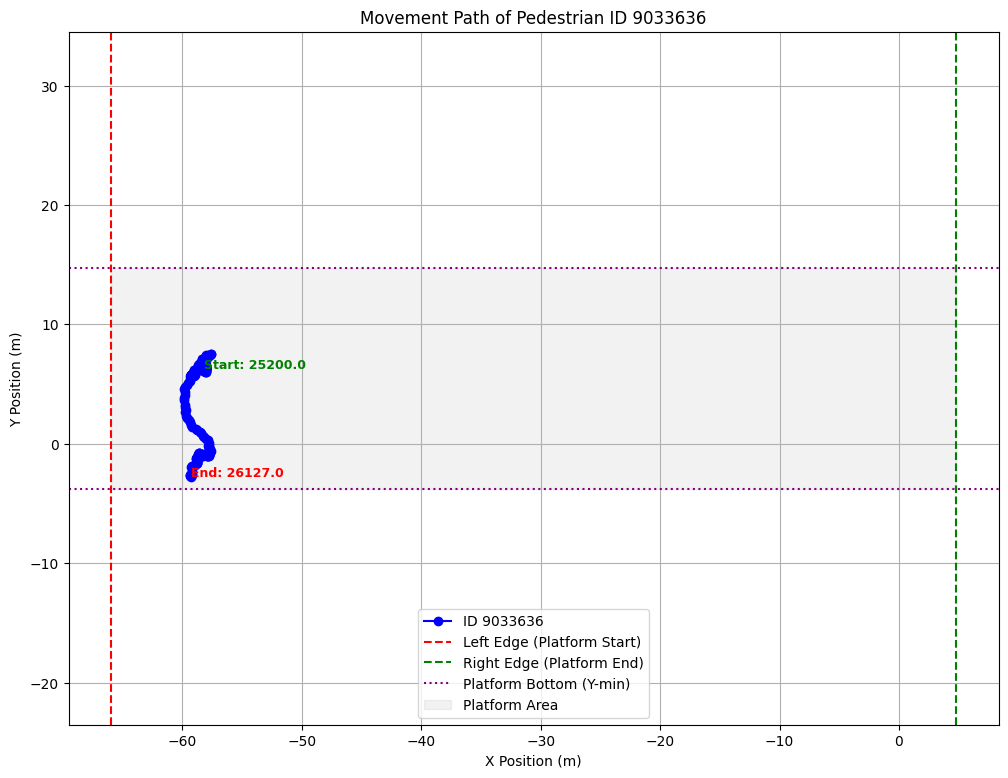

In [55]:
# Add time-in-seconds column
agg_df_rush_morning_8_9["second"] = agg_df_rush_morning_8_9["frame"] // 4
# Plot boarding examples
plot_person_with_platform_edges(agg_df_rush_morning_8_9, 9033636)



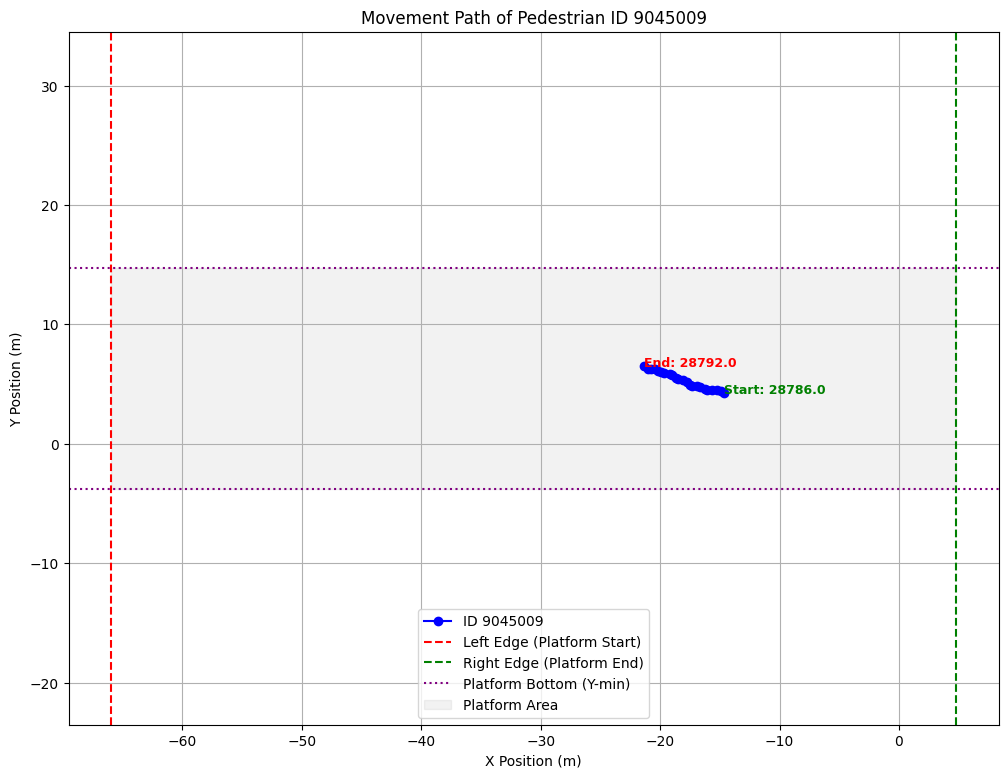

In [56]:
# Plot boarding examples
plot_person_with_platform_edges(agg_df_rush_morning_8_9, 9045009)

1    61.5
Name: time_duration_sec, dtype: float64


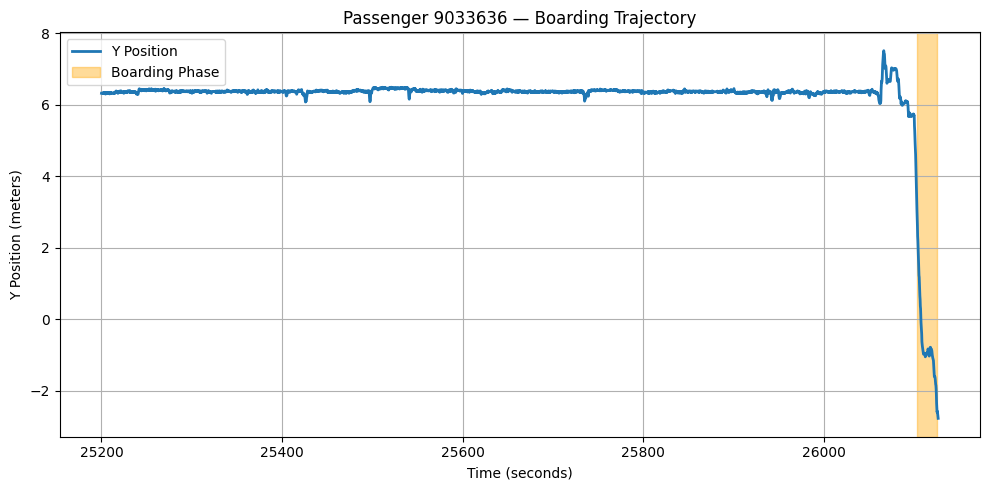

In [66]:
# Filter one passenger's data
# Filter one passenger's data
print(final_movement_times[final_movement_times["id"] == 9033636]["time_duration_sec"])
df_one = agg_df_rush_morning_8_9[agg_df_rush_morning_8_9['id'] == 9033636]
# 9033636
# Call plot function
plot_boarding_alighting_time(df_one, category='boarding')

3745    4.0
Name: time_duration_sec, dtype: float64


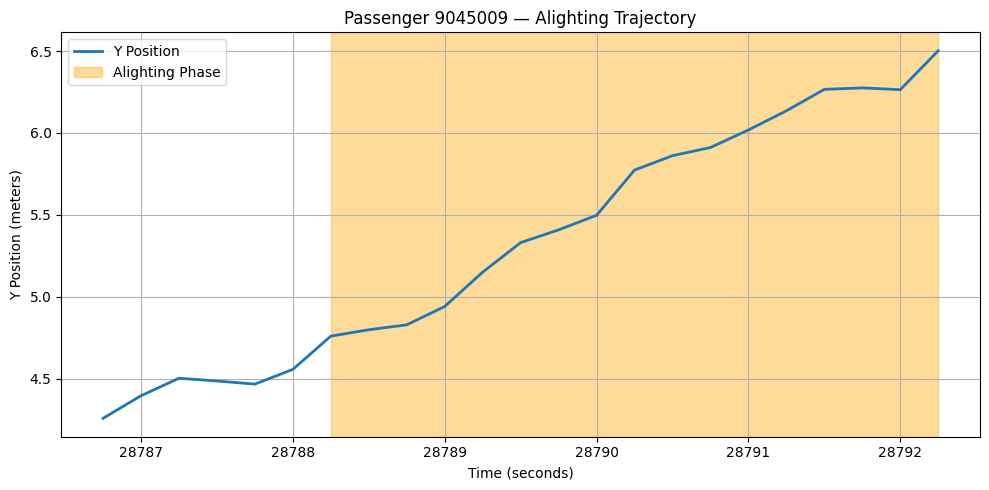

In [65]:
# Filter one passenger's data
print(final_movement_times[final_movement_times["id"] == 9045009]["time_duration_sec"])
df_one = agg_df_rush_morning_8_9[agg_df_rush_morning_8_9['id'] == 9045009]
# Call plot function
plot_boarding_alighting_time(df_one, category='alighting')


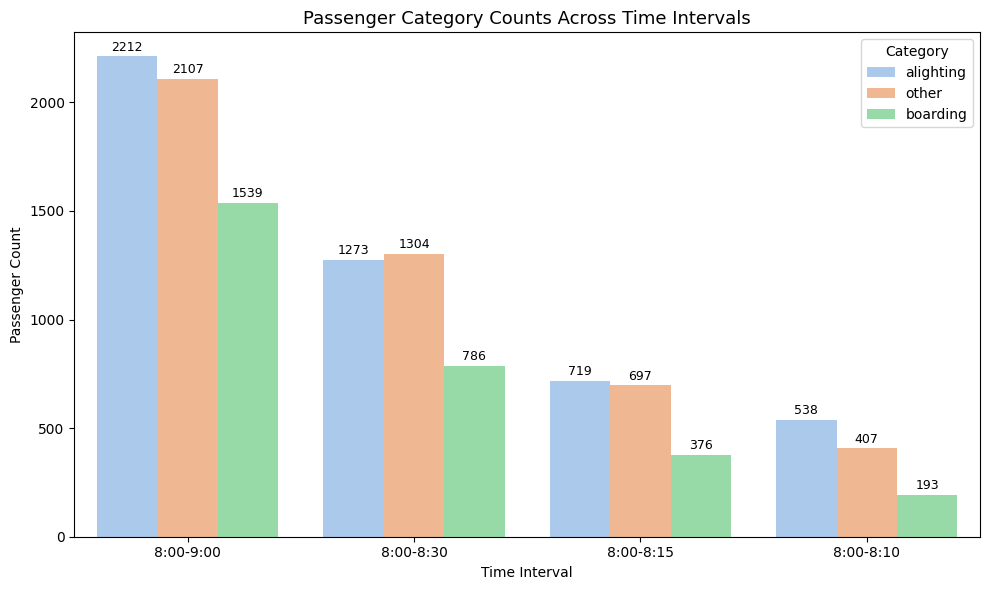

In [39]:
# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='Time Interval', y='Count', hue='Category', palette='pastel')

# Title and labels
plt.title('Passenger Category Counts Across Time Intervals', fontsize=13)
plt.xlabel('Time Interval')
plt.ylabel('Passenger Count')

# Add count labels on top of each bar
for container in plt.gca().containers:
    plt.bar_label(container, fmt='%d', label_type='edge', padding=2, fontsize=9)

plt.tight_layout()
plt.show()


Interpretation:
Alighting dominates in all time intervals, especially during the full hour (8:00–9:00) with 2212 passengers.

Other activities (e.g., waiting, loitering, or passing through) are consistently high but slowly decline with shorter intervals.

Boarding is the lowest in all intervals, but still significant.

The number of passengers in all categories drops sharply when narrowing the window:

From 8:00–9:00 to 8:00–8:30: ~40% drop.

From 8:00–8:30 to 8:00–8:15: ~40% drop again.

This indicates a high concentration of activity around 8:00–8:10, especially for alighting.

## Final Insights:
Switching from a static measurement line to a dynamic one based on density valleys makes our approach:

Adaptive to real-world passenger behavior

Less biased by arbitrary coordinate assumptions

More robust in distinguishing crossing events, especially during high-volume periods like 8–9 AM

### References:
Detecting transition lines based on the spatial density valleys allows for robust separation of movement phases, particularly when using perpendicular scan lines in high-density pedestrian environments."
— Adapted from Zhan et al. (2008), “Finding transition lines in trajectory data”

Seer, S., Brändle, N., & Uhl, M. (2014). “Analyzing passenger behavior in railway stations using trajectory data.” Transportation Research Procedia.

Kretz, T., et al. (2011). “Quick and reliable detection of bottlenecks in pedestrian facilities.”

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create the data dictionary
data = {
    'Time Interval': ['8:00-9:00', '8:00-8:30', '8:00-8:15', '8:00-8:10'],
    'alighting': [2212, 1273, 719, 538],
    'other': [2107, 1304, 697, 407],
    'boarding': [1539, 786, 376, 193]
}

# Convert to DataFrame
df_time_interval_count = pd.DataFrame(data)

# Melt for seaborn plotting
df_melted = df_time_interval_count.melt(id_vars='Time Interval', var_name='Category', value_name='Count')


In [51]:
import matplotlib.pyplot as plt

def plot_boarding_alighting_time(df_person, category, frame_rate=4, y_thresh=0.2):
    """
    Plots Y position over time and highlights only the boarding/alighting time window.

    Parameters:
    - df_person: DataFrame with 'frame', 'y', and 'id' for a single passenger
    - category: 'boarding' or 'alighting'
    - frame_rate: frames per second
    - y_thresh: Y-diff threshold to detect movement
    """
    df = df_person.sort_values('frame').reset_index(drop=True).copy()
    df['y_diff'] = df['y'].diff().abs().fillna(0)
    df['moving'] = df['y_diff'] > y_thresh
    df['time_sec'] = df['frame'] / frame_rate

    # Get movement indices
    movement_indices = df.index[df['moving']].tolist()

    if not movement_indices:
        print("No significant movement detected.")
        return

    if category == 'alighting':
        # Use the first segment (up to 10 frames)
        start_idx = movement_indices[0]
        end_idx = movement_indices[min(9, len(movement_indices) - 1)]
    elif category == 'boarding':
        # Use the last segment (last 10 frames)
        end_idx = movement_indices[-1]
        start_idx = movement_indices[max(0, len(movement_indices) - 10)]
    else:
        raise ValueError("Category must be 'boarding' or 'alighting'.")

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(df['time_sec'], df['y'], label='Y Position', linewidth=2)

    # Highlight boarding/alighting window
    plt.axvspan(df['time_sec'].iloc[start_idx], df['time_sec'].iloc[end_idx],
                color='orange', alpha=0.4, label=f'{category.title()} Phase')

    plt.title(f"Passenger {df['id'].iloc[0]} — {category.title()} Trajectory")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Y Position (meters)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [61]:
def get_relaxed_movement_time(df_person, category, frame_rate=4, y_thresh=0.2, min_movement_frames=1):
    """
    Relaxed version to compute boarding or alighting time based on Y movement.

    Parameters:
    - df_person: DataFrame for one person (must include 'frame' and 'y')
    - category: 'boarding' or 'alighting'
    - frame_rate: how many frames per second
    - y_thresh: min movement in Y to be considered meaningful
    - min_movement_frames: minimum number of movement frames to consider a valid phase

    Returns:
    - duration in seconds
    """
    df = df_person.sort_values('frame').copy()
    df['y_diff'] = df['y'].diff().abs().fillna(0)

    # Filter significant movement
    movement_df = df[df['y_diff'] > y_thresh]
    if len(movement_df) < min_movement_frames:
        return 0.0

    if category == 'boarding':
        # Take the last N movement frames
        subset = movement_df.tail(min(20, len(movement_df)))
    elif category == 'alighting':
        # Take the first N movement frames
        subset = movement_df.head(min(20, len(movement_df)))
    else:
        raise ValueError("Category must be 'boarding' or 'alighting'.")

    start_frame = subset['frame'].iloc[0]
    end_frame = subset['frame'].iloc[-1]

    duration_frames = max(end_frame - start_frame, 0)
    return round(duration_frames / frame_rate, 2)
results = []

for idx, row in result_df.iterrows():
    pid = row['id']
    cat = row['category']
    if cat in ["boarding", "alighting"]:
    # Filter main df for this id only
      df_person = agg_df_rush_morning_8_9[(agg_df_rush_morning_8_9['id'] == pid)]

      # Call your get_movement_time function
      movement_time = get_relaxed_movement_time(df_person, category=cat)

      # Append result
      results.append({'id': pid, 'category': cat, 'time_duration_sec': movement_time})

# Create new DataFrame with results
final_movement_times = pd.DataFrame(results)
print(final_movement_times.head())



        id  category  time_duration_sec
0  9033370  boarding              14.50
1  9033636  boarding              61.50
2  9033755  boarding              10.25
3  9034080  boarding              10.25
4  9034169  boarding               3.75


In [47]:
import matplotlib.pyplot as plt

def plot_person_with_platform_edges(agg_df_rush_morning, person_id, platform_left_x=-66, platform_right_x=4.8,
                                    platform_ymin=-3.77, platform_ymax=14.75):

    person_df = agg_df_rush_morning[agg_df_rush_morning["id"] == person_id].copy()
    plt.figure(figsize=(12, 9))

    # Plot movement path
    plt.plot(person_df["x"], person_df["y"], 'o-', color="blue", label=f"ID {person_id}")

    # Annotate only start and end frame numbers
    start_row = person_df.iloc[0]
    end_row = person_df.iloc[-1]

    plt.text(start_row["x"], start_row["y"], f"Start: {start_row['second']}", fontsize=9, color='green', weight='bold')
    plt.text(end_row["x"], end_row["y"], f"End: {end_row['second']}", fontsize=9, color='red', weight='bold')

    # Platform edges
    plt.axvline(x=platform_left_x, color='red', linestyle='--', label="Left Edge (Platform Start)")
    plt.axvline(x=platform_right_x, color='green', linestyle='--', label="Right Edge (Platform End)")
    plt.axhline(y=platform_ymin, color='purple', linestyle=':', label="Platform Bottom (Y-min)")
    plt.axhline(y=platform_ymax, color='purple', linestyle=':')

    # Platform area
    plt.fill_betweenx([platform_ymin, platform_ymax], platform_left_x, platform_right_x,
                      color='gray', alpha=0.1, label="Platform Area")

    plt.xlabel("X Position (m)")
    plt.ylabel("Y Position (m)")
    plt.title(f"Movement Path of Pedestrian ID {person_id}")
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()


In [44]:
rush_start_8_00 = 100800
rush_end_8_15 = rush_start_8_00 + 10 * 60 * 4  # 3600 frames

agg_df_8_00_to_8_15 = df[(df['frame'] >= rush_start_8_00) & (df['frame'] < rush_end_8_15)].copy()

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks

# Extract Y positions
y_values = agg_df_8_00_to_8_15['y'].values

# Compute KDE
kde = gaussian_kde(y_values, bw_method='scott')
y_grid = np.linspace(min(y_values), max(y_values), 1000)
density = kde(y_grid)

# Find peaks and valleys
peaks, _ = find_peaks(density, distance=20)
valleys, _ = find_peaks(-density, distance=20)

# Plot KDE
plt.figure(figsize=(10, 6))
plt.plot(y_grid, density, label='KDE of Y-position', color='blue')

# Overlay peaks
plt.plot(y_grid[peaks], density[peaks], 'ro', label='Peaks (High density zones)')

# Overlay valleys
plt.plot(y_grid[valleys], density[valleys], 'go', label='Valleys (Zone separators / M-line candidates)')

# Annotate M-line candidates
for v in valleys:
    plt.axvline(x=y_grid[v], color='gray', linestyle='--', alpha=0.4)
    plt.text(y_grid[v], max(density)*0.9, f'M{v}', rotation=90, color='gray')

# Labels and legend
plt.title("KDE of Y-Position with Peaks and Valleys")
plt.xlabel("Y Position (meters)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# zone_boundaries are the y positions at valleys
zone_boundaries = y_grid[valleys]
result_df = categorize_passengers(agg_df_8_00_to_8_15, zone_boundaries)
print(result_df['category'].value_counts())

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Count occurrences of each category
category_counts = result_df['category'].value_counts().reset_index()
category_counts.columns = ['category', 'count']

# Calculate total passengers
total_passengers = category_counts['count'].sum()

# Plotting
plt.figure(figsize=(8, 5))
sns.barplot(x='category', y='count', data=category_counts, palette='pastel')

# Add count labels on top of bars
for i, row in category_counts.iterrows():
    plt.text(i, row['count'] + 10, row['count'], ha='center', va='bottom')

# Add titles and labels
plt.title(f'Passenger Count from 8 AM to 8.15 AM\nTotal Passengers: {total_passengers}', fontsize=14, fontweight='bold')
plt.xlabel('Category')
plt.ylabel('Count')
plt.tight_layout()
plt.show()



In [ ]:
# Results for each static measurement Line.

In [4]:
m_line_values = [-3.17, -2.61, -1.60, -0.72,  0.65,  1.28,  2.22, 2.97]
import pandas as pd
import matplotlib.pyplot as plt

# Example category count Series for each threshold
t0 = pd.Series({'other': 81467, 'boarding': 172, 'alighting': 0})
t1 = pd.Series({'other': 80163, 'boarding': 1449, 'alighting': 27})
t2 = pd.Series({'other': 73023, 'boarding': 5779, 'alighting': 2837})
t3 = pd.Series({'other': 70306, 'boarding': 6237, 'alighting': 5096})
t4 = pd.Series({'other': 69095, 'boarding': 7262, 'alighting': 5282})
t5 = pd.Series({'other': 68772, 'boarding': 7602, 'alighting': 5265})
t6 = pd.Series({'other': 67266, 'boarding': 8461, 'alighting': 5912})
t7 = pd.Series({'other': 63354, 'boarding': 10833, 'alighting': 7452})
# Combine into a single DataFrame
df_plotting_category_classification = pd.DataFrame({
    'T0': t0,
    'T1': t1,
    'T2': t2,
    'T3': t3,
    'T4': t4,
    'T5': t5,
    'T6': t6,
    'T7': t7
}).T  # Transpose so each row is a threshold
# Add M Line column
df_plotting_category_classification['Measurement  Line'] = m_line_values


In [ ]:
import matplotlib.pyplot as plt

def plot_person_with_platform_edges(person_id, platform_left_x=-66, platform_right_x=4.8,
                                    platform_ymin=-3.77, platform_ymax=14.75):

    person_df = agg_df[agg_df["id"] == person_id].copy()
    plt.figure(figsize=(12, 9))

    # Plot movement path
    plt.plot(person_df["x"], person_df["y"], 'o-', color="blue", label=f"ID {person_id}")

    # Annotate only start and end frame numbers
    start_row = person_df.iloc[0]
    end_row = person_df.iloc[-1]

    plt.text(start_row["x"], start_row["y"], f"Start: {start_row['second']}", fontsize=9, color='green', weight='bold')
    plt.text(end_row["x"], end_row["y"], f"End: {end_row['second']}", fontsize=9, color='red', weight='bold')

    # Platform edges
    plt.axvline(x=platform_left_x, color='red', linestyle='--', label="Left Edge (Platform Start)")
    plt.axvline(x=platform_right_x, color='green', linestyle='--', label="Right Edge (Platform End)")
    plt.axhline(y=platform_ymin, color='purple', linestyle=':', label="Platform Bottom (Y-min)")
    plt.axhline(y=platform_ymax, color='purple', linestyle=':')

    # Platform area
    plt.fill_betweenx([platform_ymin, platform_ymax], platform_left_x, platform_right_x,
                      color='gray', alpha=0.1, label="Platform Area")

    plt.xlabel("X Position (m)")
    plt.ylabel("Y Position (m)")
    plt.title(f"Movement Path of Pedestrian ID {person_id}")
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()
